# Region of interest

This notebook detects signals, or regions of interest, in a spectrogram generated from a recording of the natural acoustic environment.

#### Required packages

[scipy](https://github.com/scipy/scipy) <br />
[numpy](https://github.com/numpy/numpy) <br />
[nacoustik](https://github.com/jacobdein/nacoustik) <br />
[matplotlib](https://github.com/matplotlib/matplotlib)

#### Import statements

In [1]:
import numpy as np
from scipy.ndimage import label, find_objects
from scipy.ndimage.morphology import generate_binary_structure
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from nacoustik import Wave
from nacoustik.spectrum import psd
from nacoustik.noise import remove_background_noise
%matplotlib inline

#### Variable definitions

filepath — path to a WAV file

In [2]:
filepath = ""

## Compute spectrogram

In [3]:
sound = Wave(filepath)
sound.read()
sound.normalize()
f, t, a = psd(sound)

## Remove background noise

refer to the [Adaptive level equalization](https://github.com/jacobdein/alpine-soundscapes/blob/master/source%20detection/Adaptive%20level%20equalization.ipynb) notebook for details 

In [4]:
ale = remove_background_noise(a, iterations=10)

## Label regions of interest

define structure connectivity

In [5]:
s = generate_binary_structure(2, 2)
s

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]], dtype=bool)

In [6]:
labels = np.empty_like(ale, dtype=np.int32)
n_features = np.empty(shape=(2), dtype=np.int32)
for channel in range(sound.n_channels):
    labels[channel], n_features[channel] = label(ale[channel], structure=s)

## Plot regions of interest

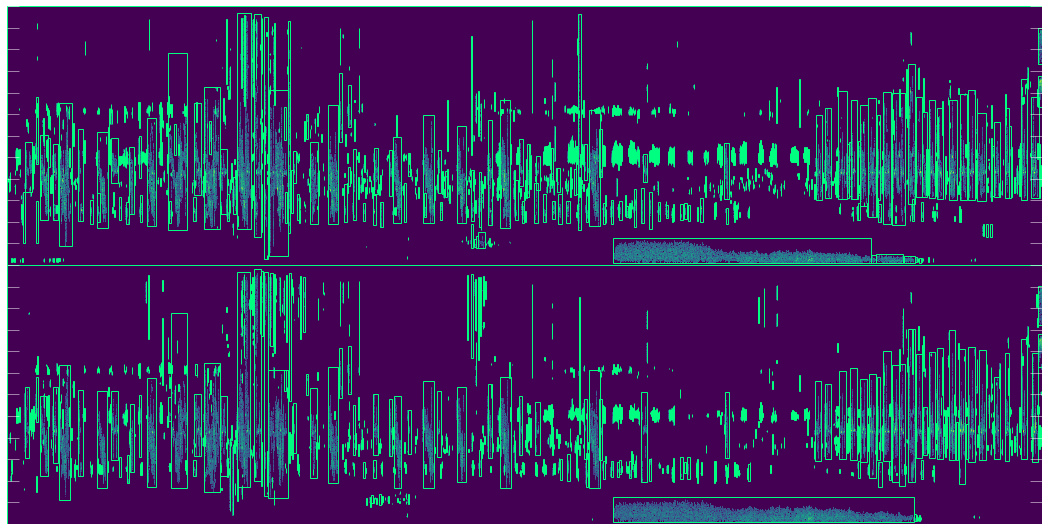

In [7]:
# figure configuration
dpi = 192
channels = sound.n_channels
fig, ax = plt.subplots(channels, 1)
fig.set_dpi(dpi)
fig.set_figwidth((920 / dpi) * 3)
fig.set_figheight((460 / dpi) * 3)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
fig.set_frameon(False)

# specify frequency bins (width of 1 kiloherz)
bins = np.arange(0, (sound.rate / 2), 1000)

# calculate the t_step and f_step
t_step = t[1] - t[0]
f_step = f[1] - f[0]

# psd spectrogram ale
for channel in range(channels):
    spec = ax[channel].pcolormesh(t, f, ale[channel], cmap='viridis')
    ax[channel].set(ylim=([0, sound.rate / 2]),
                  #xticks = np.arange(30, sound.duration, 30).astype(np.int),
                  yticks = bins.astype(np.int) + 1000)
    ax[channel].tick_params(length=12, color='white',
                          bottom=False, labelbottom=False,
                          top=False, labeltop=False,
                          labelleft=False,
                          labelright=False)
    ax[channel].set_frame_on(False)
    
    # draw bounding boxes
    for i in range(labels[channel].max()):
        loc = find_objects(labels[channel] == i)[0]
        x = loc[1].start * t_step
        y = loc[0].start * f_step
        width = (loc[1].stop - loc[1].start) * t_step
        height = (loc[0].stop - loc[0].start) * f_step
        rec = Rectangle((x, y), width = width, height = height, color='#00FF80', fill=False)
        p = ax[channel].add_patch(rec)